# Libri speech Classification baselines 

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import sys 
import os
from os import path, makedirs
import numpy as np 
import matplotlib.pyplot as plt

import torch
# import torchvision 
import torch.optim as optim
import torch.nn as nn

sys.path.insert(0, '../../Utils')
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import codecs
import fnmatch
import pandas as pd
import requests
import progressbar #
import subprocess
import tarfile
import unicodedata

#from sox import Transformer #
from tensorflow.python.platform import gfile

# import models
# from train import *
# from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
# n_epochs = 30
# batch_size = 128
# lr = 0.0001
# criterion = nn.CrossEntropyLoss()

## Load LibriSpeech data set

In [81]:
def maybe_download(archive_name, target_dir, archive_url):
    # If archive file does not exist, download it...
    archive_path = path.join(target_dir, archive_name)

    if not path.exists(target_dir):
        print('No path "%s" - creating ...' % target_dir)
        makedirs(target_dir)

    if not path.exists(archive_path):
        print('No archive "%s" - downloading...' % archive_path)
        req = requests.get(archive_url, stream=True)
        total_size = int(req.headers.get('content-length', 0))
        done = 0
        with open(archive_path, 'wb') as f:
            for data in req.iter_content(1024*1024):
                done += len(data)
                f.write(data)
    else:
        print('Found archive "%s" - not downloading.' % archive_path)
    return archive_path

def _download_and_preprocess_data(data_dir):
    # Conditionally download data to data_dir
    print("Downloading Librivox data set (55GB) into {} if not already present...".format(data_dir))
   
    TRAIN_CLEAN_100_URL = "http://www.openslr.org/resources/12/train-clean-100.tar.gz"
    TRAIN_CLEAN_360_URL = "http://www.openslr.org/resources/12/train-clean-360.tar.gz"
#     TRAIN_OTHER_500_URL = "http://www.openslr.org/resources/12/train-other-500.tar.gz"

    DEV_CLEAN_URL = "http://www.openslr.org/resources/12/dev-clean.tar.gz"
    DEV_OTHER_URL = "http://www.openslr.org/resources/12/dev-other.tar.gz"

    TEST_CLEAN_URL = "http://www.openslr.org/resources/12/test-clean.tar.gz"
    TEST_OTHER_URL = "http://www.openslr.org/resources/12/test-other.tar.gz"

    def filename_of(x): return os.path.split(x)[1]
    train_clean_100 = maybe_download(filename_of(TRAIN_CLEAN_100_URL), data_dir, TRAIN_CLEAN_100_URL)
    train_clean_360 = maybe_download(filename_of(TRAIN_CLEAN_360_URL), data_dir, TRAIN_CLEAN_360_URL)
#     train_other_500 = maybe_download(filename_of(TRAIN_OTHER_500_URL), data_dir, TRAIN_OTHER_500_URL)

    dev_clean = maybe_download(filename_of(DEV_CLEAN_URL), data_dir, DEV_CLEAN_URL)
    dev_other = maybe_download(filename_of(DEV_OTHER_URL), data_dir, DEV_OTHER_URL)


    test_clean = maybe_download(filename_of(TEST_CLEAN_URL), data_dir, TEST_CLEAN_URL)
    test_other = maybe_download(filename_of(TEST_OTHER_URL), data_dir, TEST_OTHER_URL)

    # Conditionally extract LibriSpeech data
    # We extract each archive into data_dir, but test for existence in
    # data_dir/LibriSpeech because the archives share that root.
    print("Extracting librivox data if not already extracted...")

    LIBRIVOX_DIR = "LibriSpeech"
    work_dir = os.path.join(data_dir, LIBRIVOX_DIR)

    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "train-clean-100"), train_clean_100)
    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "train-clean-360"), train_clean_360)
#     _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "train-other-500"), train_other_500)

    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "dev-clean"), dev_clean)
    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "dev-other"), dev_other)

    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "test-clean"), test_clean)
    _maybe_extract(data_dir, os.path.join(LIBRIVOX_DIR, "test-other"), test_other)

    # Convert FLAC data to wav, from:
    #  data_dir/LibriSpeech/split/1/2/1-2-3.flac
    # to:
    #  data_dir/LibriSpeech/split-wav/1-2-3.wav
    #
    # And split LibriSpeech transcriptions, from:
    #  data_dir/LibriSpeech/split/1/2/1-2.trans.txt
    # to:
    #  data_dir/LibriSpeech/split-wav/1-2-0.txt
    #  data_dir/LibriSpeech/split-wav/1-2-1.txt
    #  data_dir/LibriSpeech/split-wav/1-2-2.txt
    #  ...
#     print("Converting FLAC to WAV and splitting transcriptions...")

    print("Splitting transcriptions and creating dataframes...")
    
    train_100 = _convert_audio_and_split_sentences(work_dir, "train-clean-100", "train-clean-100-wav")
    train_360 = _convert_audio_and_split_sentences(work_dir, "train-clean-360", "train-clean-360-wav")
#     train_500 = _convert_audio_and_split_sentences(work_dir, "train-other-500", "train-other-500-wav")

    dev_clean = _convert_audio_and_split_sentences(work_dir, "dev-clean", "dev-clean-wav")
    dev_other = _convert_audio_and_split_sentences(work_dir, "dev-other", "dev-other-wav")

    test_clean = _convert_audio_and_split_sentences(work_dir, "test-clean", "test-clean-wav")
    test_other = _convert_audio_and_split_sentences(work_dir, "test-other", "test-other-wav")

    # Write sets to disk as CSV files
    train_100.to_csv(os.path.join(data_dir, "librivox-train-clean-100.csv"), index=False)
    train_360.to_csv(os.path.join(data_dir, "librivox-train-clean-360.csv"), index=False)
#     train_500.to_csv(os.path.join(data_dir, "librivox-train-other-500.csv"), index=False)

    dev_clean.to_csv(os.path.join(data_dir, "librivox-dev-clean.csv"), index=False)
    dev_other.to_csv(os.path.join(data_dir, "librivox-dev-other.csv"), index=False)

    test_clean.to_csv(os.path.join(data_dir, "librivox-test-clean.csv"), index=False)
    test_other.to_csv(os.path.join(data_dir, "librivox-test-other.csv"), index=False)
    
    return train_100, dev_clean,test_clean

def _maybe_extract(data_dir, extracted_data, archive):
    # If data_dir/extracted_data does not exist, extract archive in data_dir
    if not gfile.Exists(os.path.join(data_dir, extracted_data)):
        tar = tarfile.open(archive)
        tar.extractall(data_dir)
        tar.close()

def _convert_audio_and_split_sentences(extracted_dir, data_set, dest_dir):
    source_dir = os.path.join(extracted_dir, data_set)
    target_dir = os.path.join(extracted_dir, dest_dir)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop over transcription files and split each one
    #
    # The format for each file 1-2.trans.txt is:
    #  1-2-0 transcription of 1-2-0.flac
    #  1-2-1 transcription of 1-2-1.flac
    #  ...
    #
    # Each file is then split into several files:
    #  1-2-0.txt (contains transcription of 1-2-0.flac)
    #  1-2-1.txt (contains transcription of 1-2-1.flac)
    #  ...
    #
    # We also convert the corresponding FLACs to WAV in the same pass
    files = []
    for root, dirnames, filenames in os.walk(source_dir):
        for filename in fnmatch.filter(filenames, '*.trans.txt'):
            trans_filename = os.path.join(root, filename)
            with codecs.open(trans_filename, "r", "utf-8") as fin:
                for line in fin:
                    # Parse each segment line
                    first_space = line.find(" ")
                    seqid, transcript = line[:first_space], line[first_space+1:]

                    # We need to do the encode-decode dance here because encode
                    # returns a bytes() object on Python 3, and text_to_char_array
                    # expects a string.
                    transcript = unicodedata.normalize("NFKD", transcript)  \
                                            .encode("ascii", "ignore")      \
                                            .decode("ascii", "ignore")

                    transcript = transcript.lower().strip()

                    ##No conversion for now
#                     # Convert corresponding FLAC to a WAV
                    flac_file = os.path.join(root, seqid + ".flac")
#                     wav_file = os.path.join(target_dir, seqid + ".wav")
#                     if not os.path.exists(wav_file):
#                         Transformer().build(flac_file, wav_file)
                    flac_filesize = os.path.getsize(flac_file)

                    files.append((os.path.abspath(flac_file), flac_filesize, transcript))

    return pd.DataFrame(data=files, columns=["flac_filename", "flac_filesize", "transcript"])

if __name__ == "__main__":
    train_100,dev_clean,test_clean = _download_and_preprocess_data(sys.argv[1])
    
#code adapted from https://github.com/mozilla/DeepSpeech/blob/master/bin/import_librivox.py

In [47]:
# print an example transcript
print(train_100.loc[0,'transcript'])

In [3]:
# below ~15 cells all adapted from https://github.com/aravindnatarajan/SpeakerRecognition
#
#   Speaker Identification.
#   Data comes from http://www.openslr.org/12/
#   Task: Given 't' seconds of speech, identify the speaker.
#   10-class classification: 5 male and 5 female speakers.
#   Training on about 10 minutes of speech per speaker.
#
#
import soundfile as sf            # To read .flac files.   
import speech_recognition as sr   # pip install SpeechRecognition.

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For the neural network.
# Install PyBrain, e.g. pip install pybrain.
from pybrain.datasets                import ClassificationDataSet
from pybrain.tools.shortcuts         import buildNetwork
from pybrain.supervised.trainers     import BackpropTrainer
from pybrain.structure.modules       import SoftmaxLayer
from pybrain.tools.customxml.networkreader import NetworkReader
from pybrain.tools.customxml.networkwriter import NetworkWriter

from pybrain.structure import FullConnection
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer
from pybrain.structure import TanhLayer

sq = lambda x: x*x

durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz.  
audioType  = ".flac"               # Flac files. 
path       = "-f/LibriSpeech/"        # Path where audio files are located.
trainSet   = "train-speakerID/"        # Training set.
cvSet      = "cv-speakerID/"           # Cross-Validation set.
tstSet     = "test-speakerID/"         # Test set. 
maxminFile = "min_max_values.dat"  # File to store max and min values for each frequency bin.
outfolder  = "networks/"           # Folder to store trained networks.
stem       = "nn"                  # Output network filename stem.    

# These are the speakers.
# Female: 19, 32, 39, 40, 83
# Male: 26, 27, 78, 405, 196
speakers = ["19/",
            "26/",
            "32/",
            "27/",
            "39/",
            "78/",
            "40/",
            "405/", 
            "83/",
            "196/"]

numFeatures = lim2-lim1
numSpeakers = len(speakers)

In [85]:
# split training data from one speaker into test & cross-validation folders

# -*- coding: utf-8 -*-
# @author: Peter Lamut

import os
import shutil

def move_files(abs_dirname,speaker):
    """Move files into subdirectories."""

    for subdir in os.listdir(abs_dirname):
        files = [os.path.join(abs_dirname,subdir, f) for f in os.listdir(os.path.join(abs_dirname,subdir))]  
        cv_dir = os.path.abspath(os.path.join(path + cvSet  + speaker))
        cv_subdir = os.path.join(cv_dir,subdir)
        test_dir = os.path.abspath(os.path.join(path + tstSet  + speaker))
        test_subdir = os.path.join(test_dir,subdir)
        if not os.path.isdir(test_subdir):
            if not os.path.isdir(test_dir):
                os.mkdir(cv_dir)
                os.mkdir(test_dir)
            os.mkdir(cv_subdir)
            os.mkdir(test_subdir)
            
            #separate files
            # 1 test
            # 2 cv
            # 3,4,5 train
            # 6 test
            # 7 cv
            # 8,9,0 train
            ncv = [2,7]
            ntest = [1,6]
            
            
            for f in files:
                num = f[-9:-5]
                if num != 'tran':
                    rem = int(num) % 10

                    if rem in ncv: #move to cv

                    # move file to target dir
                        f_base = os.path.basename(f)
                        shutil.move(f, cv_subdir)
                    elif rem in ntest:

                    # move file to target dir
                        f_base = os.path.basename(f)
                        shutil.move(f, test_subdir)

def main():

    for speaker in speakers:
        print(speaker)
        src_dir = path + trainSet + speaker

        if not os.path.exists(src_dir):
            raise Exception('Directory does not exist ({0}).'.format(src_dir))

        move_files(os.path.abspath(src_dir),speaker)


if __name__ == '__main__':
    main()

In [4]:
# Read data from a folder into a list.
def getData(division,speaker):
  fname = path+division+speaker  
  subPaths = [v+"/" for v in os.listdir(fname) if v[0] != "."]
  dataFiles = []
  for subPath in subPaths:
    files = [v for v in os.listdir(fname+subPath) if v[0] != "." and audioType in v]
    for fil in files:
      data,samplerate = sf.read(fname+subPath+fil)  
      duration = len(data)*1./samplerate
      if duration >= durationCheck: dataFiles.append(fname+subPath+fil)
        
  chunksF = []

  for fil in dataFiles:
    data,samplerate = sf.read(fil)  
    duration = len(data)*1./samplerate

    # Divide audio data into frames, or chunks. 
    numChunks = int(duration/deltaT)
    sizeChunk = int(len(data)/numChunks)
    for lp in range(0,numChunks):    
      chunk = data[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
      chunksF.append(np.abs(np.fft.rfft(chunk))[lim1:lim2])  # take the FFT.

    # Delete quiet parts of speech, i.e. pauses.
    # Most of the power is in the bottom 50% of frequencies.
    mu = np.mean([np.mean(chunksF[i][:numFeatures//2]) for i in range(0,len(chunksF))])
    dataF = []
    for chunkF in chunksF:
      if np.mean(chunkF[:numFeatures//2]) > noisy*mu:
        dataF.append(chunkF)
    
  return dataF

# Return data for all speakers.
def getDataSpeakers(division):
  dataSpeakers = []
  for speaker in speakers:
    print("Getting data for speaker: "+speaker)
    dataSpeakers.append(getData(division,speaker))

  N = np.sum([np.shape(s)[0] for s in dataSpeakers])
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  speakerIndices = [0]    # Index corresponding to start of speaker 'n'
  
  ctr = 0; lp = 0
  for dataSpeaker in dataSpeakers:
    for j in range(0,len(dataSpeaker)):
      for k in range(0,numFeatures):
        tX[ctr,k] = dataSpeaker[j][k]
      tY.append(lp)
      ctr += 1  
    speakerIndices.append(ctr)
    lp += 1  
          
  return tX,tY,speakerIndices

In [5]:
# Get data,
# as well as locations where speaker 'i' ends, and speaker 'j' begins.
trnX,trnY,trnIdx = getDataSpeakers(trainSet)  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/


In [6]:
print(np.shape(trnX), np.shape(trnY)    )
trnRows = np.shape(trnX)[0]
print(trnIdx)   # Start location of speaker 'i'.

(32079, 400) (32079,)
[0, 3445, 6755, 9899, 11854, 15528, 18353, 21818, 25108, 28533, 32079]


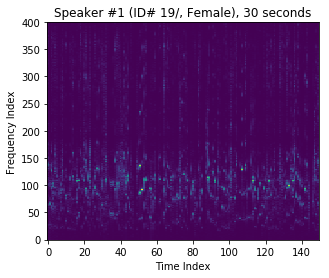

In [7]:
# Make some plots.
# Frequency index from 0...400 represent a range from 50 - 2000 Hz.
# Time index from 0 to 150 represent a range from 0 - 30 seconds.
plt.title("Speaker #1 (ID# 19/, Female), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[0]:trnIdx[0]+150,:].T,origin="lower",aspect=0.3)

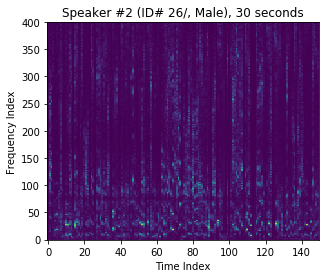

In [8]:
plt.title("Speaker #2 (ID# 26/, Male), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[1]:trnIdx[1]+150,:].T,origin="lower",aspect=0.3)

In [9]:
# Find min and max values for each frequency bin using Training data only.
# Normalize data to lie in the range (0,1).
minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trnX[:,i]))
  maxArray.append(np.max(trnX[:,i]))    

f = open(maxminFile, "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      

for i in range(0,trnRows):
  for j in range(0,numFeatures):
    trnX[i,j] = (trnX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

In [10]:
# 
# This is the architecture of the network.
# Hyper-parameters to be fixed through cross-validation are:
#                         (i)   How many layers are necessary?
#                         (ii)  How many nodes per layer?
#                         (iii) What kind of activation function to use?
# 
def setupNetwork(numHiddenNodes,numHiddenLayers):
    
  nn = FeedForwardNetwork()
  inputLayer = LinearLayer(numFeatures)
  nn.addInputModule(inputLayer)
  
  hiddenLayers = []
  for x in range(numHiddenLayers):
    hiddenLayer = TanhLayer(numHiddenNodes)    
    nn.addModule(hiddenLayer)
    hiddenLayers.append(hiddenLayer)
  outputLayer = SoftmaxLayer(numSpeakers)
  nn.addOutputModule(outputLayer)
  
  inputConnection = FullConnection(inputLayer,hiddenLayers[0])
  nn.addConnection(inputConnection)
  
  for x in range(numHiddenLayers-1):
    connect = FullConnection(hiddenLayers[x],hiddenLayers[x-1])
    nn.addConnection(connect)

  outputConnection = FullConnection(hiddenLayers[numHiddenLayers-1],outputLayer)    
  nn.addConnection(outputConnection)
  nn.sortModules()
  
  return nn

In [129]:
#
# Now, we train the neural network.
#
possibleOutputs   = 1       # Only 1 kind of output, i.e. each sample is one speaker.
numHiddenNodes    = 10      # Nodes per hidden layer.
numHiddenLayers   = 5       # 5 layers.
numTrainingEpochs = 20      # Train 'n' epochs.

trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numSpeakers)
for row in range(0,trnRows):
  tempListOut = []; tempListIn = []
  tempListOut.append(int(trnY[row]))
  for i in range(0,numFeatures): 
    tempListIn.append(trnX[row,i])
    
  trndata.addSample(tempListIn,tempListOut)
trndata._convertToOneOfMany()

first = True            # Set up a network.
# first = False            # We already have a network.
nnFile = "nn43.xml"      # Most recent. Starting file name to read from.
st = 50                  # Starting file to write to.

if first:    # For the first time, we need to create the neural network.
  nn = setupNetwork(numHiddenNodes,numHiddenLayers)

else:        # We already have a network.
  nn = NetworkReader.readFrom(outfolder+nnFile)
    
trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
for i in range(numTrainingEpochs): 
  trainer.trainOnDataset(dataset=trndata)    
  if (i+1)%5 == 0:
    NetworkWriter.writeToFile(nn, outfolder+stem+str(st)+".xml")  # Save the network, to save time.
    st += 1
    print (i+1)

In [17]:
#
# Test the classifier.
# nns is a list of trained networks. It is sometimes helpful to pass more than one network,
# since errors made by different networks may cancel out.
# tX: Data to test
# tY: Target, i.e. speaker ID.
# idx: List of indices indicating the starting location of a speaker.
# skip: Number of increments of 'deltaT' to group together. For e.g. if 'deltaT' = 0.2:
#       If skip = 1, a prediction is made for every 0.2 seconds.
#       If skip = 5, a prediction is made for every 1.0 second.
#
def tstClassifier(nns,tX,tY,idx,skip):

  def maxIdx(A):
    # Pick the prediction with the highest occurance.
    ctr = {}
    for pre in A:
      if pre not in ctr: ctr[pre] = 1
      else: ctr[pre] += 1
      
    rev = {}
    for key in ctr.keys():
      rev[ctr[key]] = key
    return rev[np.max(list(rev.keys()))]

  # Confusion matrix: Speaker 'm' predicted as speaker 'n'.
  confusion = np.mat(np.zeros((numSpeakers,numSpeakers)))  
  
  correct = 0; al = 0
  for cvi in range(0,numSpeakers):
    # idx contain the start location of each speaker.
    for lpx in range(idx[cvi],idx[cvi+1]-skip,skip):
      bestArray = []

      # Consider "skip" number of data points together.
      for lp in range(lpx,lpx+skip):      
        A = [tX[lp,i] for i in range(0,numFeatures)]
        prediction = []

        # Average over multiple trained networks.        
        for nn in nns:  
          pred = nn.activate(A)
          ctr = {}
          for i in range(0,numSpeakers):
            ctr[pred[i]] = i
          prediction.append(ctr[np.max(list(ctr.keys()))])
        bestArray.append(maxIdx(prediction))

      best = maxIdx(bestArray)                
      if best == tY[lpx]: correct += 1

      # Populate the confusion matrix.  
      for i in range(0,numSpeakers):
        if best == i: confusion[cvi,i] += 1
      al += 1

  return correct*1./al, confusion

In [18]:
#
# Data for cross-validation and testing.
# We use the cross validation data set to determine the network architecture,
# i.e. depth and width of the network, type of activation function, etc.
#
cvX,cvY,cvIdx = getDataSpeakers(cvSet)  
tstX,tstY,tstIdx = getDataSpeakers(tstSet)  
cvRows = np.shape(cvX)[0]; tstRows = np.shape(tstX)[0]

f = open(maxminFile)    # Read the max and min values obtained from the training set.
maxi = []; mini = []
for lp in range(0,numFeatures):
  line = f.readline().split()
  maxi.append(float(line[0]))
  mini.append(float(line[1]))
f.close()

# Normalize to put data in the range (0,1).
for i in range(0,cvRows):
  for j in range(0,numFeatures):
    cvX[i,j] = (cvX[i,j]-mini[j])/(maxi[j]-mini[j])  

for i in range(0,tstRows):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-mini[j])/(maxi[j]-mini[j])  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/
Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/


In [ ]:
#
# Performance on the CV set, as a function of training epoch.
# We stop when we see signs of overfitting.
# Performance on the CV set is also used to determine the neural network architecture.
#
lastN = 39
print("CV Set - Performance on 0.2 seconds of data.")
X = []; Y = []
for q in range(0,lastN):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = tstClassifier(nn,cvX,cvY,cvIdx,st)
  if q%5 == 0:
    print(net,st*deltaT,np.mean(A))
  X.append((q+1)*5)
  Y.append(np.mean(A))

CV Set - Performance on 0.2 seconds of data.
networks/nn0.xml 0.2 0.5774077407740774
networks/nn5.xml 0.2 0.697029702970297
networks/nn10.xml 0.2 0.7255625562556256
networks/nn15.xml 0.2 0.7267326732673267
networks/nn20.xml 0.2 0.7301530153015302
networks/nn25.xml 0.2 0.7237623762376237


In [132]:
#
#  The network is trained using performance on the CV set.
#  Therefore, we cannot report perfomance on the CV set anymore.
#  So, we use the other hold-out data set, i.e. the Test set.
#
print("Test Set - Performance on 0.2 seconds of data.")
X = []; Y = []
for q in range(0,lastN):
  net = outfolder+stem+str(q)+".xml"
  nn = [NetworkReader.readFrom(net)]
  st = 1
  A,c = tstClassifier(nn,tstX,tstY,tstIdx,st)
  if q%5 == 0:
    print(net,st*deltaT,np.mean(A))
  X.append((q+1)*5)
  Y.append(np.mean(A))

In [136]:
plt.xlabel("Training epoch index")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Performance on the test set with 0.2 seconds of speech")
plt.plot(X,Y)
plt.show()

In [123]:
#
#  Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... seconds.
#
print("Test Set: Accuracy (averaged over speakers) for t = 0.2,0.4,0.6,... seconds")
# Use 5 classifiers - the accuracy improves a little with an ensemble of networks.
# For better results, use networks that were initialized with different random seeds.
nets = ["nn39.xml", "nn67.xml", "nn65.xml", "nn63.xml", "nn61.xml"]
nns = [NetworkReader.readFrom(outfolder+net) for net in nets]
X = []; Y = []
maxT = 3.   # 3 seconds.
for st in range(1,int(maxT/deltaT)+1):
  A,c = tstClassifier(nns,tstX,tstY,tstIdx,st)
  print(st*deltaT,np.mean(A))
  X.append(st*deltaT)
  Y.append(np.mean(A))

In [ ]:
plt.plot(X,Y)
plt.xlabel("Number of seconds of speech")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Classifier performance on the test set")
plt.show()

In [ ]:
# Print the confusion matrix of True/False positives.
# First row is speaker 1. The columns are predictions for speaker 1,2,3,...
#
nets = ["nn69.xml", "nn67.xml", "nn65.xml", "nn63.xml", "nn61.xml"]
nns  = [NetworkReader.readFrom(outfolder+net) for net in nets]
A,c = tstClassifier(nns,tstX,tstY,tstIdx,1)
print "Confusion matrix: T = 0.2 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  
print "\n"[:-1]

A,c = tstClassifier(nns,tstX,tstY,tstIdx,5)
print "Confusion matrix: T = 1 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  
print "\n"[:-1]

A,c = tstClassifier(nns,tstX,tstY,tstIdx,10)
print "Confusion matrix: T = 2 s"
print "Predicted speaker -->"
print "F\tM\tF\tM\tF\tM\tF\tM\tF\tM\n"
for i in range(0,np.shape(c)[0]):
  for j in range(0,np.shape(c)[1]):
    print str(int(c[i,j]))+"\t",
  print "\n"[:-1]  

In [ ]:
samples = [path+tstSet+"19/227/19-227-0017.flac",
           path+tstSet+"26/496/26-496-0019.flac",
           path+tstSet+"405/130895/405-130895-0030.flac"]

expected = [
"Mrs. Morland had been always kindly disposed towards each, and instantly pleased \
by his appearance, received him with the simple professions of unaffected benevolence, \
thanking him for such an attention to her daughter",
  
"Among the wealthiest of the people, and such people as were unencumbered \
with trades and business, but of the rest, the generality stayed, and seemed \
to abide the worst, so that",
  
"Some of these jellyfish were shaped like very smooth semispheric parasols \
with russet stripes, and fringes of twelve neat festoons. Others looked like"
]

r = sr.Recognizer()
i = 0
for sample in samples:
  with sr.AudioFile(sample) as source:
    audio = r.record(source)      
    s = r.recognize_google(audio)
    print "Reading file: " + sample
    print "Expected:"
    print expected[i]
    print "\n"[:-1]
    print "Obtained (Google translator):"
    print s
    print "\n"[:-1]
    i += 1

## Siamese network

In [ ]:
# add this to ~/.bashrc for the package to run:
#export PYTHONPATH=$PYTHONPATH:/home/nlopatina/nlopatina/voicemap

from keras.layers import Input, Subtract, Dense, Lambda
from keras.models import Model
import keras.backend as K

def build_siamese_network(encoder, input_shape):
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)
    
    # `encoder` is any predefined network that maps a single sample 
    # into an embedding space.
    # `encoder` should take an input with shape (None,) + input_shape
    # and produce an output with shape (None, embedding_dim). 
    # None indicates the batch dimension.
    encoded_1 = encoder(input_1)
    encoded_2 = encoder(input_2)
    
    # Here I calculate the eucliden distance between the two encoded
    # samples though other distances can be used
    embedded_distance = Subtract()([encoded_1, encoded_2])
    embedded_distance = Lambda(
        lambda x: K.sqrt(K.mean(K.square(x), axis=-1,keepdims=True))
    )(embedded_distance)
    
    # Add a dense+sigmoid layer here in order to use per-pair, binary 
    # similar/dissimilar labels
    output = Dense(1, activation='sigmoid')(embedded_distance)
    
    siamese = Model(inputs=[input_1, input_2], outputs=output)
    
    return siamese

# adapted from https://medium.com/analytics-vidhya/building-a-speaker-identification-system-from-scratch-with-deep-learning-f4c4aa558a56